In [1]:
%reset -f
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Projeto 1-2: Restauração de uma imagem de sinalização de trânsito

Você está trabalhando em um projeto da nova versão do PatoPatoVai Street View. Seu objetivo é melhorar a qualidade das imagens obtidas pela câmera do veículo, especialmente em relação ao *motion blur* (pois a câmera está fixada no carro, e os solavancos da estrada podem resultar em borramento das imagens capturadas).

Considere a imagem abaixo:

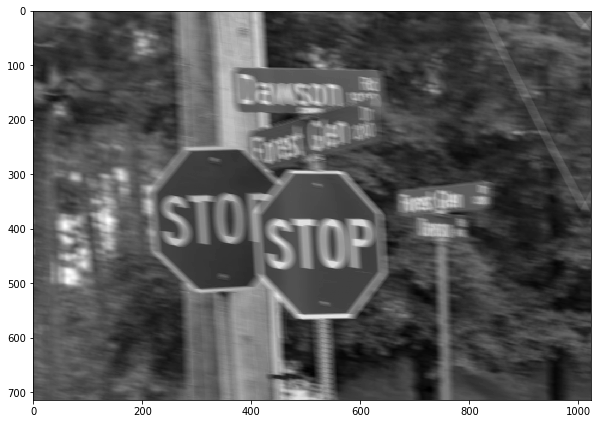

In [2]:
img_blur = cv2.cvtColor(cv2.imread('blur.png'), cv2.COLOR_BGR2GRAY) / 255.0

plt.figure(figsize=(10, 8))
plt.imshow(img_blur, cmap='gray');

Está difícil saber a que altura da rua Forest Glen estamos. Sua equipe está desenvolvendo um primeiro protótipo de um sistema que, a partir desta imagem, gera uma imagem nítida e com perspectiva corrigida de cada uma das placas indicadoras da rua.

Você foi encarregado de fazer uma primeira versão do melhoramento de imagem (*deblurring*, contraste, correção de perspectiva), onde parâmetros essenciais do *deblurring* (tamanho de kernel, orientação, tipo), do contraste e da correção de perspectiva (pontos notáveis) podem ser determinados manualmente. Na sua equipe tem outros engenheiros trabalhando no problema de detectar e segmentar as placas presentes na cena. 

Para facilitar a experimentação:

- O Scikit-Image já tem uma função que faz o filtro de Wiener: ``skimage.restoration.wiener``

- Segue código para fazer um *kernel* de *motion blur* dado o tamanho do kernel, o comprimento do segmento de reta, e o ângulo.

In [3]:
from skimage.restoration import wiener

def make_psf(shape, length, angle):
    psf = np.zeros(shape)
    rows, cols = shape
    center = (cols//2, rows//2)
    psf[center[1], center[0]:(center[0]+length)] = 1.0
    M = cv2.getRotationMatrix2D(center, angle, 1)
    psf = cv2.warpAffine(psf, M, (cols, rows))
    psf = psf / psf.sum()
    return psf

## Tarefa

Escreva um programa que:

- Corrige o *motion blur*
    - Não é necessário neste projeto que o sistema escolha automaticamente os melhores parâmetros para o *deblurring*, determine-os manualmente.

- Melhora o contraste
    - Novamente, se precisar ajustar parâmetros manualmente, tudo bem. Escolha a técnica que quiser para melhoramento de contraste.
    
- Extrai a placa de rua com correção de perspectiva.
    - Os pontos dos cantos da placa não precisam ser determinados automaticamente, escolha manualmente os pontos. A outra parte da sua equipe está trabalhando no outro problema.
    

### Rubrica

- **I**: Entregou algo sem sentido ou muito incompleto (não atinge o nível *D*)

- **D**: Entregou o projeto quase completo, mas faltaram 2 itens dentre os descritos acima.

- **C**: Entregou o projeto quase completo, mas faltou 1 item dentre os descritos acima.

- **B**: Entregou o projeto completo.

- **A**: Entregou o projeto completo e testou alguma técnica mais avançada para resolver o problema do motion-blur. Ver o artigo "Restoration of Motion-Blurred Image Based on Border Deformation Detection: A Traffic Sign Restoration Model", em anexo no Blackboard.

## Correção do Motion Blur

/usr/local/lib/python3.6/dist-packages/skimage/restoration/uft.py:447: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  impr[([slice(1, 2)] * ndim)] = 2.0 * ndim


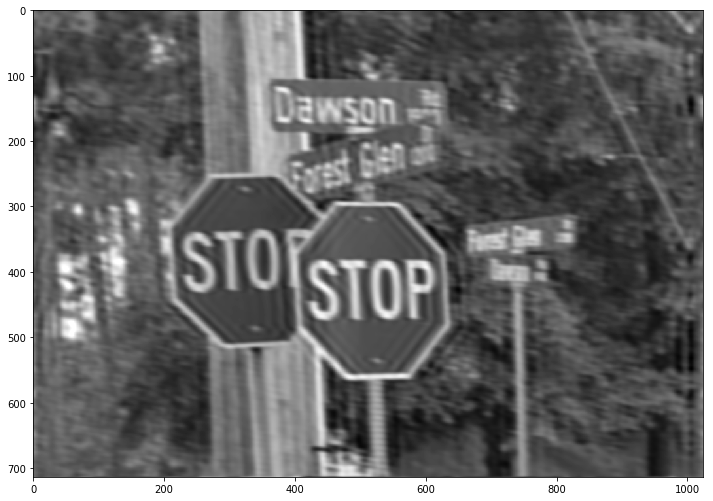

In [4]:
# Se quiser, brinca com os parâmetros, não achei nada melhor!
def correcao_motionblur(img):
    img_blur = img.copy()
    psf = make_psf(img_blur.shape, 19, -3)
    img_correct_blur = wiener(img_blur, psf, 2)
    return img_correct_blur

img_correct_blur = correcao_motionblur(img_blur)
plt.figure(figsize=(12, 12))
plt.imshow(img_correct_blur, cmap='gray');

## Melhoria do Contraste

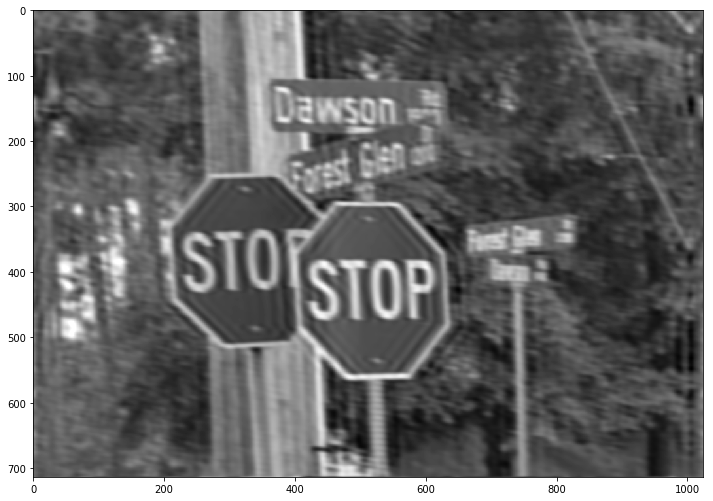

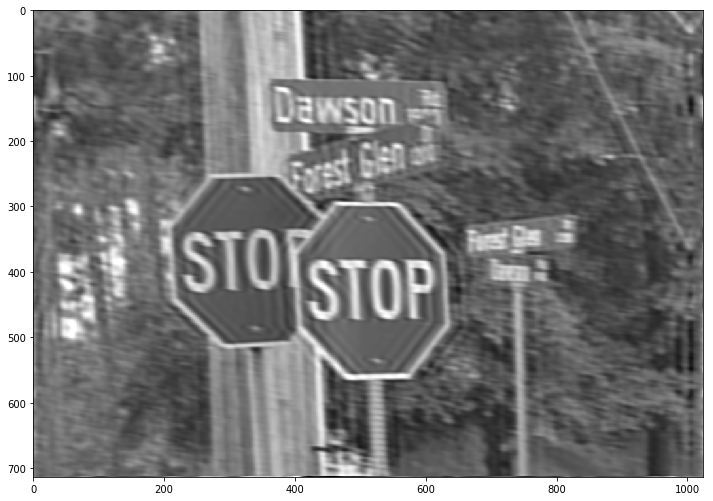

In [5]:
#Fiz o realce de imagem da aula 05
def correcao_contraste(img_blur, alpha):
    img = img_blur.copy()
    kernel = np.array([[0, -alpha, 0],[-alpha, 1.0 + 4.0*alpha, -alpha],[0, -alpha, 0]])
    img_realce = cv2.filter2D(img, -1, kernel)
    return img_realce

img_realce = correcao_contraste(img_correct_blur, 2.0)

plt.figure(figsize=(12, 12))
plt.imshow(img_correct_blur, cmap='gray')

plt.figure(figsize=(12, 12))
plt.imshow(np.clip(img_realce, 0, 1), cmap='gray')

## Correção de Perspectiva

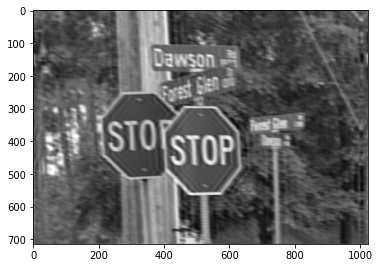

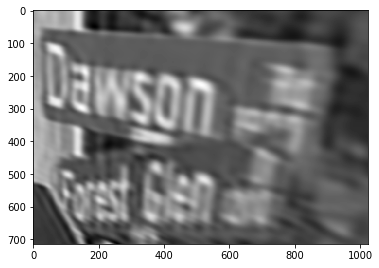

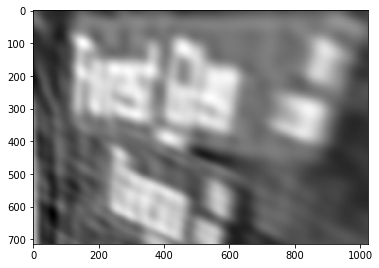

In [6]:
# https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
def correcao_perspectiva(img_blur, pontos_de_interesse):
    img = img_blur.copy()
    rows, cols = img.shape

    pts_original = np.float32(pontos_de_interesse)
    pts_corrigida = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1], [rows - 1, cols - 1]])

    M = cv2.getPerspectiveTransform(pts_original, pts_corrigida)

    img_corrigida = cv2.warpPerspective(img, M, (cols, rows))
    return img_corrigida

pontos_placa1 = [[350,90],[640,90],[350,330],[640,330]]
placa1 = correcao_perspectiva(img_realce, pontos_placa1)

pontos_placa2 = [[630,330],[830,310],[630,450],[830,450]]
placa2 = correcao_perspectiva(img_realce, pontos_placa2)

plt.figure(figsize=(6,6))
plt.imshow(img_correct_blur, cmap='gray')
plt.figure(figsize=(6,6))
plt.imshow(placa1, cmap='gray')
plt.figure(figsize=(6,6))
plt.imshow(placa2, cmap='gray')